In [1]:
import ibmos2spark
# @hidden_cell
credentials = {
    'endpoint': 'https://s3-api.us-geo.objectstorage.service.networklayer.com',
    'service_id': 'iam-ServiceId-ef9d270b-0482-42a4-8530-74b6f58c8637',
    'iam_service_endpoint': 'https://iam.ng.bluemix.net/oidc/token',
    'api_key': 'HL8qsTj_kWf6WV7gIqZejj0MaeahBcaPP3GhfBwxIyG3'
}

configuration_name = 'os_f218c58859fb4d4c8bd06402ea22458f_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20190828104204-0004
KERNEL_ID = 1c50170e-634e-4aea-861f-71aff874b6f6


In [2]:
#importing csv file
df = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .load(cos.url('try.csv', 'capstoneproject-donotdelete-pr-krtih81spsnfmj'))
df.take(5)

[Row(Date='20/02/2018', Market Cap='189536000000'),
 Row(Date='19/02/2018', Market Cap='178055000000'),
 Row(Date='18/02/2018', Market Cap='187663000000'),
 Row(Date='17/02/2018', Market Cap='172191000000'),
 Row(Date='16/02/2018', Market Cap='170960000000')]

In [3]:
#importing librairies

from pyspark.sql import Row
from pyspark.sql.types import StructType, StructField, IntegerType, DateType
import types
import pandas as pd
from ibm_botocore.client import Config
import ibm_boto3
import matplotlib.pyplot as plt


In [4]:
#defining schema

schema = StructType([
    StructField('Date', DateType(), True),
    StructField('Market Cap', IntegerType(), True),
])

In [5]:
#creating df & rdd with correct schemas

rdd = sc.textFile(cos.url('try.csv', 'capstoneproject-donotdelete-pr-krtih81spsnfmj')).map(lambda line: line.split(","))
df = sqlContext.createDataFrame(rdd, schema)
print(df)

DataFrame[Date: date, Market Cap: int]


In [6]:
#print df

df = spark.read.csv(cos.url('try.csv', 'capstoneproject-donotdelete-pr-krtih81spsnfmj'), inferSchema = True, header = True)
df.show()

+----------+------------+
|      Date|  Market Cap|
+----------+------------+
|20/02/2018|189536000000|
|19/02/2018|178055000000|
|18/02/2018|187663000000|
|17/02/2018|172191000000|
|16/02/2018|170960000000|
|15/02/2018|160025000000|
|14/02/2018|145023000000|
|13/02/2018|150516000000|
|12/02/2018|137258000000|
|11/02/2018|145245000000|
|10/02/2018|146981000000|
|09/02/2018|139412000000|
|08/02/2018|128714000000|
|07/02/2018|130683000000|
|06/02/2018|118810000000|
|05/02/2018|139325000000|
|04/02/2018|154553000000|
|03/02/2018|149085000000|
|02/02/2018|153953000000|
|01/02/2018|172372000000|
+----------+------------+
only showing top 20 rows



In [7]:
#verify that schemas are correct

df.printSchema()

root
 |-- Date: string (nullable = true)
 |-- Market Cap: long (nullable = true)



In [8]:
print((df.count(), len(df.columns)))

(1760, 2)


In [9]:
#import packages
import numpy as np
import pandas as pd
from keras.preprocessing import sequence
from keras.models import load_model

Using TensorFlow backend.


In [106]:
# defining the batch size and number of epochs
batch_size = 128
epochs = 600
timesteps = 20

In [107]:
df.select("Market Cap").collect()

[Row(Market Cap=189536000000),
 Row(Market Cap=178055000000),
 Row(Market Cap=187663000000),
 Row(Market Cap=172191000000),
 Row(Market Cap=170960000000),
 Row(Market Cap=160025000000),
 Row(Market Cap=145023000000),
 Row(Market Cap=150516000000),
 Row(Market Cap=137258000000),
 Row(Market Cap=145245000000),
 Row(Market Cap=146981000000),
 Row(Market Cap=139412000000),
 Row(Market Cap=128714000000),
 Row(Market Cap=130683000000),
 Row(Market Cap=118810000000),
 Row(Market Cap=139325000000),
 Row(Market Cap=154553000000),
 Row(Market Cap=149085000000),
 Row(Market Cap=153953000000),
 Row(Market Cap=172372000000),
 Row(Market Cap=170183000000),
 Row(Market Cap=190339000000),
 Row(Market Cap=197871000000),
 Row(Market Cap=193133000000),
 Row(Market Cap=188054000000),
 Row(Market Cap=189398000000),
 Row(Market Cap=192163000000),
 Row(Market Cap=183419000000),
 Row(Market Cap=184087000000),
 Row(Market Cap=195645000000),
 Row(Market Cap=216740000000),
 Row(Market Cap=195979000000),
 Row(Mar

In [108]:
df_array = np.array(df.select("Market Cap").collect())
print(df_array)

[[189536000000]
 [178055000000]
 [187663000000]
 ...
 [  1597780000]
 [  1491160000]
 [  1500520000]]


In [109]:
length = len(df_array)
print(length)

#test set will be 20% of entire data set  
length *= 1 - 0.2
print(length)

1760
1408.0


In [110]:
#get the length of training data set 
def get_train_length(df_array, batch_size, test_percent):
    # substract test_percent to be excluded from training, reserved for testset
    length = len(df_array)
    length *= 1 - test_percent
    train_length_values = []
    for x in range(int(length) - 100,int(length)): 
        modulo=x%batch_size
        if (modulo == 0):
            train_length_values.append(x)
            print(x)
    return (max(train_length_values))

In [111]:
length = get_train_length(df_array, batch_size, 0.15)
print(length)

1408
1408


In [112]:
#Adding timesteps * 2
upper_train = length + timesteps*2
df_train = df_array[0:upper_train]
training_set = df_train * 1.04
training_set.shape

(1448, 1)

In [113]:
# Feature Scaling i.e we scale each and every value between 0 and 1 
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(np.float64(training_set))
training_set_scaled.shape

(1448, 1)

In [114]:
X_train = []
y_train = []

# Creating a data structure with n timesteps

print(length + timesteps)
for i in range(timesteps, length + timesteps): 
    X_train.append(training_set_scaled[i-timesteps:i,0])
    y_train.append(training_set_scaled[i:i+timesteps,0])

print(len(X_train))
print(len (y_train))
print(np.array(X_train).shape)
print(np.array(y_train).shape)

1428
1408
1408
(1408, 20)
(1408, 20)


In [115]:
# Reshaping
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1], 1))
print(X_train.shape)
print(y_train.shape)

(1408, 20, 1)
(1408, 20, 1)


In [116]:
# Building the LSTM
# Importing the Keras libraries and packages

from keras.layers import Dense
from keras.layers import Input, LSTM
from keras.models import Model
import h5py

In [117]:
# Initialising the LSTM Model with MAE Loss-Function
# Using Functional API

inputs_1_mae = Input(batch_shape=(batch_size,timesteps,1))
lstm_1_mae = LSTM(10, stateful=True, return_sequences=True)(inputs_1_mae)
lstm_2_mae = LSTM(10, stateful=True, return_sequences=True)(lstm_1_mae)

output_1_mae = Dense(units = 1)(lstm_2_mae)

regressor_mae = Model(inputs=inputs_1_mae, outputs = output_1_mae)

regressor_mae.compile(optimizer='adam', loss = 'mae')
regressor_mae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (128, 20, 1)              0         
_________________________________________________________________
lstm_9 (LSTM)                (128, 20, 10)             480       
_________________________________________________________________
lstm_10 (LSTM)               (128, 20, 10)             840       
_________________________________________________________________
dense_5 (Dense)              (128, 20, 1)              11        
Total params: 1,331
Trainable params: 1,331
Non-trainable params: 0
_________________________________________________________________


In [118]:
# 1st LSTM Layer 
parameters = 4 * 10 * (1 + 10 + 1)
print(parameters)

480


In [119]:
# 2nd LSTM Layer 
parameters = 4 * 10 * (10 + 10 + 1)
print(parameters)

840


In [120]:
for i in range(epochs):
    print("Epoch: " + str(i))
    regressor_mae.fit(X_train, y_train, shuffle=False, epochs = 1, batch_size = batch_size)
    regressor_mae.reset_states()

Epoch: 0
Epoch 1/1
1408/1408 [==============================] - 4s 3ms/step - loss: 0.0874
Epoch: 1
Epoch 1/1
1408/1408 [==============================] - 0s 355us/step - loss: 0.0717
Epoch: 2
Epoch 1/1
1408/1408 [==============================] - 1s 373us/step - loss: 0.0665
Epoch: 3
Epoch 1/1
1408/1408 [==============================] - 1s 389us/step - loss: 0.0636
Epoch: 4
Epoch 1/1
1408/1408 [==============================] - 0s 333us/step - loss: 0.0585
Epoch: 5
Epoch 1/1
1408/1408 [==============================] - 1s 370us/step - loss: 0.0526
Epoch: 6
Epoch 1/1
1408/1408 [==============================] - 0s 345us/step - loss: 0.0468
Epoch: 7
Epoch 1/1
1408/1408 [==============================] - 1s 364us/step - loss: 0.0414
Epoch: 8
Epoch 1/1
1408/1408 [==============================] - 0s 327us/step - loss: 0.0376
Epoch: 9
Epoch 1/1
1408/1408 [==============================] - 1s 357us/step - loss: 0.0379
Epoch: 10
Epoch 1/1
1408/1408 [==============================] - 0s 332u

1408/1408 [==============================] - 0s 347us/step - loss: 0.0337
Epoch: 88
Epoch 1/1
1408/1408 [==============================] - 1s 361us/step - loss: 0.0324
Epoch: 89
Epoch 1/1
1408/1408 [==============================] - 0s 346us/step - loss: 0.0332
Epoch: 90
Epoch 1/1
1408/1408 [==============================] - 1s 364us/step - loss: 0.0332
Epoch: 91
Epoch 1/1
1408/1408 [==============================] - 0s 329us/step - loss: 0.0328
Epoch: 92
Epoch 1/1
1408/1408 [==============================] - 1s 411us/step - loss: 0.0330
Epoch: 93
Epoch 1/1
1408/1408 [==============================] - 0s 340us/step - loss: 0.0327
Epoch: 94
Epoch 1/1
1408/1408 [==============================] - 1s 358us/step - loss: 0.0307
Epoch: 95
Epoch 1/1
1408/1408 [==============================] - 0s 351us/step - loss: 0.0344
Epoch: 96
Epoch 1/1
1408/1408 [==============================] - 1s 384us/step - loss: 0.0320
Epoch: 97
Epoch 1/1
1408/1408 [==============================] - 0s 344us/step -

1408/1408 [==============================] - 1s 368us/step - loss: 0.0272
Epoch: 174
Epoch 1/1
1408/1408 [==============================] - 0s 337us/step - loss: 0.0269
Epoch: 175
Epoch 1/1
1408/1408 [==============================] - 1s 384us/step - loss: 0.0278
Epoch: 176
Epoch 1/1
1408/1408 [==============================] - 0s 344us/step - loss: 0.0292
Epoch: 177
Epoch 1/1
1408/1408 [==============================] - 1s 519us/step - loss: 0.0333
Epoch: 178
Epoch 1/1
1408/1408 [==============================] - 1s 392us/step - loss: 0.0324
Epoch: 179
Epoch 1/1
1408/1408 [==============================] - 1s 366us/step - loss: 0.0281
Epoch: 180
Epoch 1/1
1408/1408 [==============================] - 0s 346us/step - loss: 0.0325
Epoch: 181
Epoch 1/1
1408/1408 [==============================] - 1s 391us/step - loss: 0.0364
Epoch: 182
Epoch 1/1
1408/1408 [==============================] - 0s 343us/step - loss: 0.0293
Epoch: 183
Epoch 1/1
1408/1408 [==============================] - 1s 40

1408/1408 [==============================] - 1s 383us/step - loss: 0.0282
Epoch: 260
Epoch 1/1
1408/1408 [==============================] - 0s 348us/step - loss: 0.0274
Epoch: 261
Epoch 1/1
1408/1408 [==============================] - 1s 391us/step - loss: 0.0279
Epoch: 262
Epoch 1/1
1408/1408 [==============================] - 1s 357us/step - loss: 0.0274
Epoch: 263
Epoch 1/1
1408/1408 [==============================] - 1s 413us/step - loss: 0.0279
Epoch: 264
Epoch 1/1
1408/1408 [==============================] - 1s 356us/step - loss: 0.0269
Epoch: 265
Epoch 1/1
1408/1408 [==============================] - 1s 376us/step - loss: 0.0278
Epoch: 266
Epoch 1/1
1408/1408 [==============================] - 0s 350us/step - loss: 0.0268
Epoch: 267
Epoch 1/1
1408/1408 [==============================] - 1s 367us/step - loss: 0.0283
Epoch: 268
Epoch 1/1
1408/1408 [==============================] - 0s 343us/step - loss: 0.0263
Epoch: 269
Epoch 1/1
1408/1408 [==============================] - 1s 39

1408/1408 [==============================] - 1s 356us/step - loss: 0.0264
Epoch: 346
Epoch 1/1
1408/1408 [==============================] - 0s 353us/step - loss: 0.0274
Epoch: 347
Epoch 1/1
1408/1408 [==============================] - 1s 357us/step - loss: 0.0267
Epoch: 348
Epoch 1/1
1408/1408 [==============================] - 0s 345us/step - loss: 0.0272
Epoch: 349
Epoch 1/1
1408/1408 [==============================] - 0s 354us/step - loss: 0.0264
Epoch: 350
Epoch 1/1
1408/1408 [==============================] - 0s 349us/step - loss: 0.0265
Epoch: 351
Epoch 1/1
1408/1408 [==============================] - 1s 372us/step - loss: 0.0260
Epoch: 352
Epoch 1/1
1408/1408 [==============================] - 0s 346us/step - loss: 0.0272
Epoch: 353
Epoch 1/1
1408/1408 [==============================] - 1s 372us/step - loss: 0.0258
Epoch: 354
Epoch 1/1
1408/1408 [==============================] - 0s 354us/step - loss: 0.0255
Epoch: 355
Epoch 1/1
1408/1408 [==============================] - 1s 38

1408/1408 [==============================] - 1s 361us/step - loss: 0.0255
Epoch: 432
Epoch 1/1
1408/1408 [==============================] - 0s 344us/step - loss: 0.0300
Epoch: 433
Epoch 1/1
1408/1408 [==============================] - 1s 427us/step - loss: 0.0279
Epoch: 434
Epoch 1/1
1408/1408 [==============================] - 0s 348us/step - loss: 0.0277
Epoch: 435
Epoch 1/1
1408/1408 [==============================] - 1s 359us/step - loss: 0.0311
Epoch: 436
Epoch 1/1
1408/1408 [==============================] - 0s 350us/step - loss: 0.0259
Epoch: 437
Epoch 1/1
1408/1408 [==============================] - 1s 581us/step - loss: 0.0252
Epoch: 438
Epoch 1/1
1408/1408 [==============================] - 1s 369us/step - loss: 0.0290
Epoch: 439
Epoch 1/1
1408/1408 [==============================] - 0s 343us/step - loss: 0.0284
Epoch: 440
Epoch 1/1
1408/1408 [==============================] - 1s 368us/step - loss: 0.0272
Epoch: 441
Epoch 1/1
1408/1408 [==============================] - 1s 35

1408/1408 [==============================] - 1s 361us/step - loss: 0.0232
Epoch: 518
Epoch 1/1
1408/1408 [==============================] - 0s 340us/step - loss: 0.0237
Epoch: 519
Epoch 1/1
1408/1408 [==============================] - 0s 339us/step - loss: 0.0281
Epoch: 520
Epoch 1/1
1408/1408 [==============================] - 1s 371us/step - loss: 0.0229
Epoch: 521
Epoch 1/1
1408/1408 [==============================] - 1s 412us/step - loss: 0.0242
Epoch: 522
Epoch 1/1
1408/1408 [==============================] - 0s 354us/step - loss: 0.0291
Epoch: 523
Epoch 1/1
1408/1408 [==============================] - 1s 377us/step - loss: 0.0228
Epoch: 524
Epoch 1/1
1408/1408 [==============================] - 0s 338us/step - loss: 0.0228
Epoch: 525
Epoch 1/1
1408/1408 [==============================] - 1s 361us/step - loss: 0.0267
Epoch: 526
Epoch 1/1
1408/1408 [==============================] - 1s 367us/step - loss: 0.0254
Epoch: 527
Epoch 1/1
1408/1408 [==============================] - 0s 35

In [121]:
!pwd
!ls models/*.h5

/home/spark/shared
ls: cannot access 'models/*.h5': No such file or directory


In [122]:
def get_test_length(df_array, batch_size):
    
    test_length_values = []
    for x in range(len(df_array) - 200, len(df_array) - timesteps*2): 
        modulo=(x-upper_train)%batch_size
        if (modulo == 0):
            test_length_values.append(x)
            print(x)
    return (max(test_length_values))

In [123]:
test_length = get_test_length(df_array, batch_size)
print(test_length)
upper_test = test_length + timesteps*2
testset_length = test_length - upper_train
print(testset_length)


1576
1704
1704
256


In [124]:
print(upper_train, upper_test, len(df_array))

1448 1744 1760


In [125]:
# construct test set

#subsetting
df_test = df_array[upper_train:upper_test] 
test_set = df_test * 1.04

#scaling
scaled_real_bcg_values_test = sc.fit_transform(np.float64(test_set))

#creating input data
X_test = []
for i in range(timesteps, testset_length + timesteps):
    X_test.append(scaled_real_bcg_values_test[i-timesteps:i, 0])
X_test = np.array(X_test)


#reshaping
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [126]:
#prediction
predicted_bcg_values_test_mae = regressor_mae.predict(X_test, batch_size=batch_size)
regressor_mae.reset_states()

print(predicted_bcg_values_test_mae.shape)

#reshaping
predicted_bcg_values_test_mae = np.reshape(predicted_bcg_values_test_mae, 
                                       (predicted_bcg_values_test_mae.shape[0], 
                                        predicted_bcg_values_test_mae.shape[1]))

print(predicted_bcg_values_test_mae.shape)
#inverse transform
predicted_bcg_values_test_mae = sc.inverse_transform(predicted_bcg_values_test_mae)


#creating y_test data
y_test = []
for j in range(0, testset_length - timesteps):
    y_test = np.append(y_test, predicted_bcg_values_test_mae[j, timesteps-1])

# reshaping
y_test = np.reshape(y_test, (y_test.shape[0], 1))

print(y_test.shape)

(256, 20, 1)
(256, 20)
(236, 1)


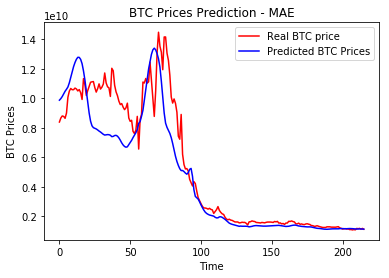

In [127]:
# Visualising the results
plt.plot(test_set[timesteps:len(y_test)], color = 'red', label = 'Real BTC price')
plt.plot(y_test[0:len(y_test) - timesteps], color = 'blue', label = 'Predicted BTC Prices')
plt.title('BTC Prices Prediction - MAE')
plt.xlabel('Time')
plt.ylabel('BTC Prices')
plt.legend()
plt.show()

In [128]:
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(test_set[timesteps:len(y_test)], y_test[0:len(y_test) - timesteps]))
print(rmse)

1661178292.961886


In [129]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(test_set[timesteps:len(y_test)], y_test[0:len(y_test) - timesteps])
print(mae)

1035266758.3703704
